# LSTM Autoencoder 
## Tennessee Eastman Process Simulation Dataset

Source: https://www.kaggle.com/datasets/averkij/tennessee-eastman-process-simulation-dataset

In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from model.autoencoder import LSTMAutoencoder, LSTMAutoencoderTransformer
from data.process import TEPDataLoader
from data.utils import get_missing_values_table
from data.plot import plot_encoded_variables

import plotly.graph_objects as go
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn import set_config
set_config(display="diagram")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading datasets

In [3]:
# create the loader class instance
loader = TEPDataLoader('data/raw')
# load the training dataset
X_train_faulty, X_train_normal = loader.load_training_datasets()

50it [01:48,  2.18s/it]
3it [00:05,  1.76s/it]


## Model Evaluation

The model is trained by running the `train_autoencoder.py` scrip. The notebook will then read the saved models to perform the analysis.

### Autoencoder
#### Training

In [4]:
# Measured process data in the multiphase batch process are usually stored in the form of a three-dimensional cube
# I×J×K, recording K measured points with J process variables of all the I simulations
I = X_train_normal.simulationRun.unique().shape[0]
K = X_train_normal['sample'].unique().shape[0]
J = len(X_train_normal.columns[3:])
print(f'I: {I}, J: {J}, K: {K}')

I: 500, J: 52, K: 500


In [26]:
# load the trained model
model = LSTMAutoencoder('data/models/v0/model_keras.h5')
# import the transformer
transformer = joblib.load('data/models/v0/transformer.pkl')
# define constants
window = 1
# create the datasets
X_train_transf = transformer.transform(X_train_normal)
# create the training dataset
X_train_windowed = LSTMAutoencoder.created_windowed_dataset(X_train_transf, window=window, batch_size=K)

#### Validation
First let's have a look at the training history. Notice that the model tents to reduce its generalization capabilities as the number of epochs increase. Looking at the chart, it is possible to notice that 30 epochs yields the best balance between training and validation loss.

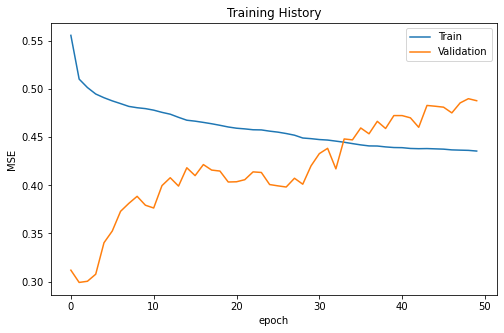

In [27]:
# plot the loss per training epoch
model.plot_history()

Next, let's plot how the reconstruction looks like.

In [28]:
def inverse_transform(X, batch_size=K, window=window, transformer=None):
    if(transformer is not None):
        return transformer.inverse_transform(LSTMAutoencoder.reverse_windowed_dataset(X, batch_size, window))
    return LSTMAutoencoder.reverse_windowed_dataset(X, batch_size, window)
# calculate the predictions
X_pred = model.predict(X_train_windowed)
X_train_pred = pd.DataFrame(inverse_transform(X_pred), columns=transformer.selected_columns)

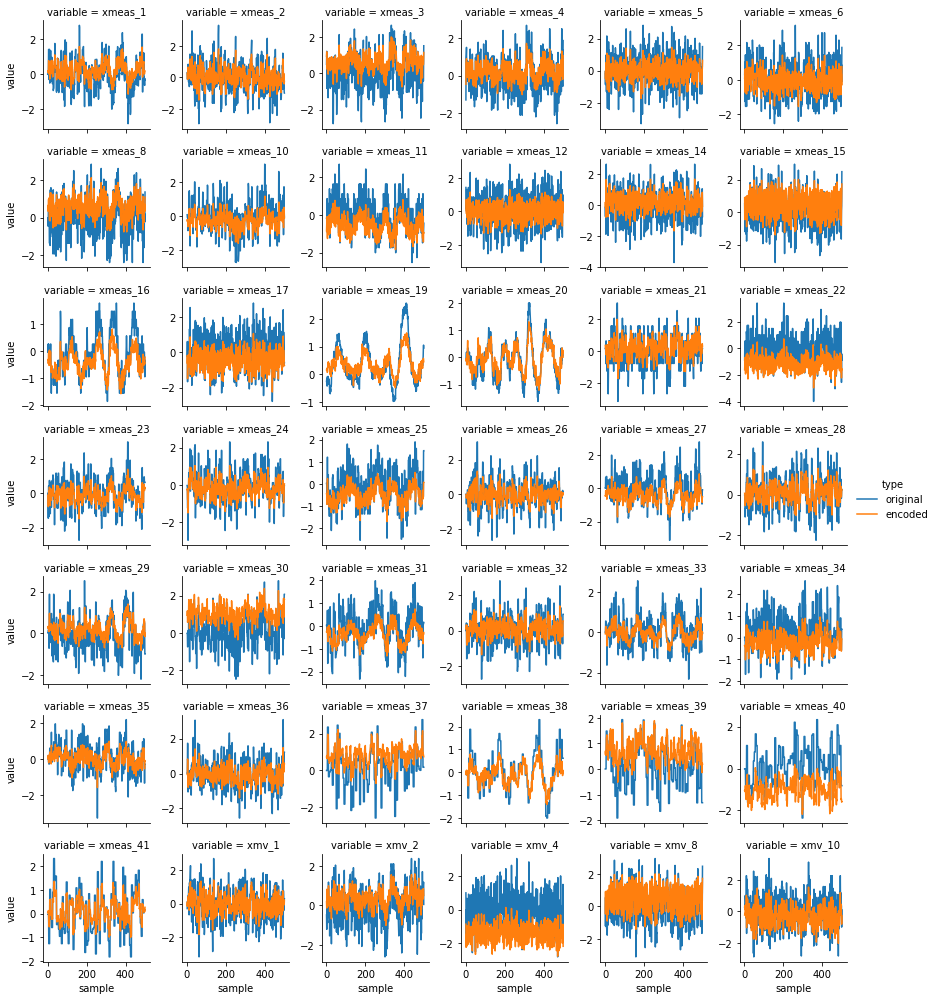

In [29]:
# plot the comparison between acatual and encoded signals
X_train_transf = pd.DataFrame(X_train_transf, columns=transformer.selected_columns)
X_train_transf['faultNumber'] = X_train_normal.faultNumber.values
X_train_transf['simulationRun'] = X_train_normal.simulationRun.values
X_train_transf['sample'] = X_train_normal['sample'].values

X_train_pred['faultNumber'] = X_train_normal.faultNumber.values
X_train_pred['simulationRun'] = X_train_normal.simulationRun.values
X_train_pred['sample'] = X_train_normal['sample'].values

plot_encoded_variables(X_train_transf, X_train_pred, transformer.selected_columns,  1)

#### Test dataset

Initially, the final version of the model is loaded, obtained for 30 epochs of training time. Next, the test dataset is loaded and the reconstruction error is evaluated.

In [30]:
# load the trained model
model = LSTMAutoencoder('data/models/final/model_keras.h5')
# import the transformer
transformer = joblib.load('data/models/final/transformer.pkl')

In [32]:
X_test_normal = loader._load('fault_free_testing.csv')

5it [00:07,  1.48s/it]


In [33]:
# define constants
window = 1
# create the datasets
X_test_transf = transformer.transform(X_test_normal)
# create the training dataset
K_test = X_test_normal['sample'].unique().shape[0]
X_test_windowed = LSTMAutoencoder.created_windowed_dataset(X_test_transf, window=window, batch_size=K_test)

In [34]:
# calculate the predictions
X_pred = model.predict(X_test_windowed)
X_test_pred = pd.DataFrame(inverse_transform(X_pred), columns=transformer.selected_columns)

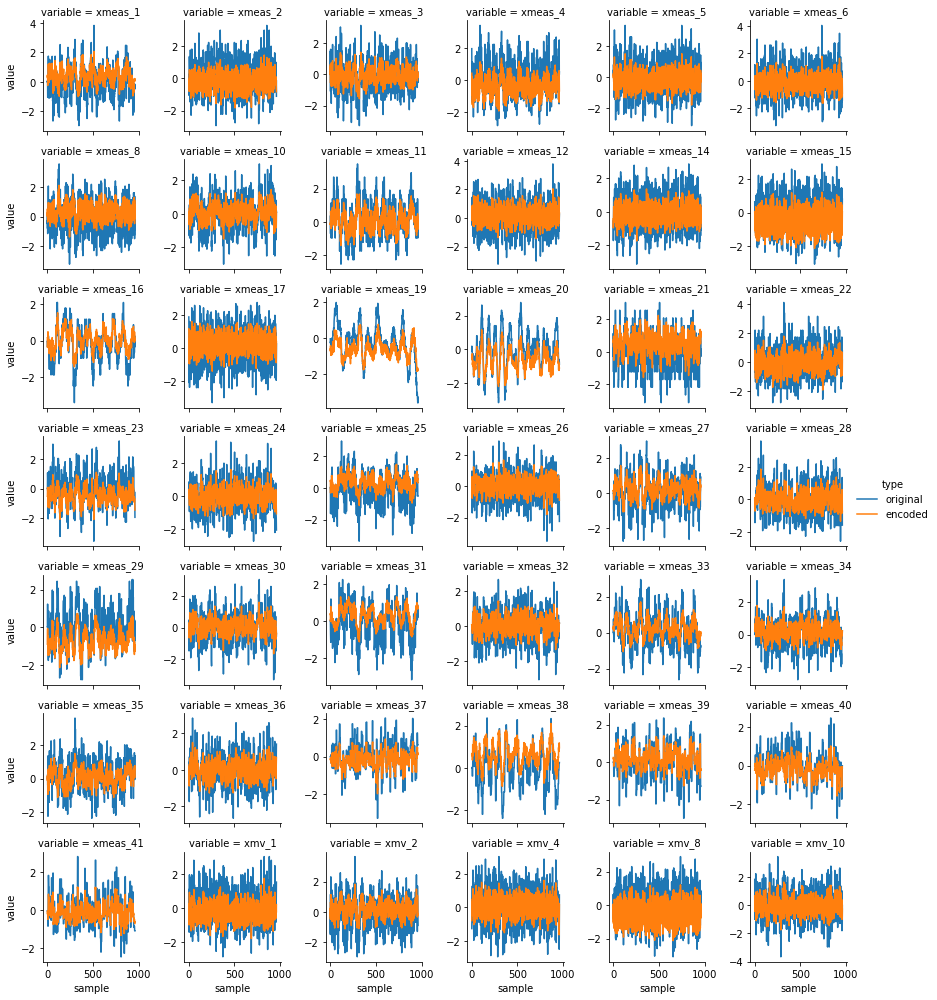

In [35]:
# plot the comparison between acatual and encoded signals
X_test_transf = pd.DataFrame(X_test_transf, columns=transformer.selected_columns)
X_test_transf['faultNumber'] = X_test_normal.faultNumber.values
X_test_transf['simulationRun'] = X_test_normal.simulationRun.values
X_test_transf['sample'] = X_test_normal['sample'].values

X_test_pred['faultNumber'] = X_test_normal.faultNumber.values
X_test_pred['simulationRun'] = X_test_normal.simulationRun.values
X_test_pred['sample'] = X_test_normal['sample'].values

plot_encoded_variables(X_test_transf, X_test_pred, transformer.selected_columns,  1)

Finally, let's have a look at the reconstruction error between the training and test normal datasets. Notice that the distribution of the error remais the same, meaning the model was able to generalizae well for the training and test datasets.

In [39]:
train_loss_mae

xmeas_1          0.456882
xmeas_2          0.409002
xmeas_3          0.663617
xmeas_4          0.465806
xmeas_5          0.416995
xmeas_6          0.438482
xmeas_8          0.633926
xmeas_10         0.479101
xmeas_11         0.644148
xmeas_12         0.427972
xmeas_14         0.438558
xmeas_15         0.475779
xmeas_16         0.485742
xmeas_17         0.550732
xmeas_19         0.501045
xmeas_20         0.394798
xmeas_21         0.443461
xmeas_22         1.138540
xmeas_23         0.437164
xmeas_24         0.424765
xmeas_25         0.562169
xmeas_26         0.410254
xmeas_27         0.568502
xmeas_28         0.413673
xmeas_29         0.494000
xmeas_30         1.005592
xmeas_31         0.510183
xmeas_32         0.414708
xmeas_33         0.456447
xmeas_34         0.504488
xmeas_35         0.432506
xmeas_36         0.426674
xmeas_37         0.781704
xmeas_38         0.446089
xmeas_39         0.710643
xmeas_40         1.059247
xmeas_41         0.404773
xmv_1            0.397850
xmv_2       

/home/victor/miniconda3/envs/dev-udacity-capstone/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


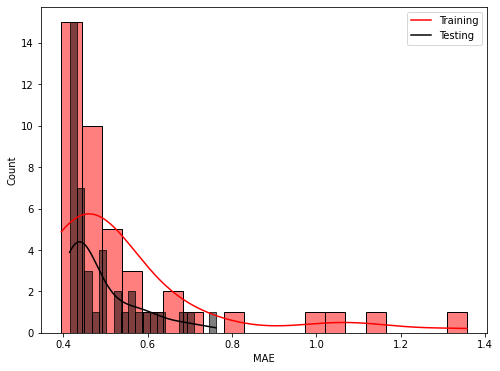

In [41]:
train_loss_mae = np.mean(np.abs(X_train_pred - X_train_transf))
test_loss_mae = np.mean(np.abs(X_test_pred - X_test_transf))
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x=train_loss_mae[:-3], kde=True, bins=20, color='red')
sns.histplot(x=test_loss_mae[:-3], kde=True, bins=20, color='black')
ax.set_xlabel('MAE')
ax.legend(['Training', 'Testing'])

### Anomaly Detection

In [ ]:
def evaluate_results(X_train_pred, pv_columns):
    X_train_pred = pd.DataFrame(inverse_transform(X_train_pred), columns=pv_columns, index=X_train.index)
    X_train_scaled = pd.DataFrame(X_train_transf, columns=pv_columns, index=X_train.index)

    loss_mae = np.mean(np.abs(X_train_pred - X_train_scaled))

    fig, ax = plt.subplots()
    sns.histplot(x=loss_mae, kde=True, bins=20)

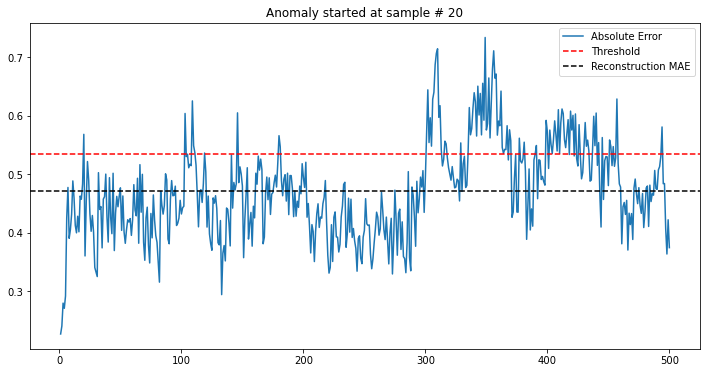

In [11]:
normal_pred_df = X_train_normal[pv_columns].copy()
normal_pred_df['faultNumber'] = X_train_normal.faultNumber.values
normal_pred_df['simulationRun'] = X_train_normal.simulationRun.values
normal_pred_df['sample'] = X_train_normal['sample'].values
normal_pred_df['loss_mae'] = np.mean(np.abs(X_train_pred - X_train_scaled), axis=1)

# plot the anomaly location
def plot_simulation_anomalies(df, simulation_run, threshold):    
    df_sim = df[(df.simulationRun == simulation_run)]
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(df_sim['sample'], df_sim['loss_mae'], label='Absolute Error')
    ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax.axhline(y=np.mean(df_sim['loss_mae']), color='k', linestyle='--', label='Reconstruction MAE')
    ax.set_title(f"Anomaly started at {df_sim[df_sim['loss_mae']>threshold]['sample'].values[0]*3} minutes")
    ax.legend()
    fig.show()

threshold = np.percentile(loss_mae, 99)
plot_simulation_anomalies(normal_pred_df, 2, threshold)

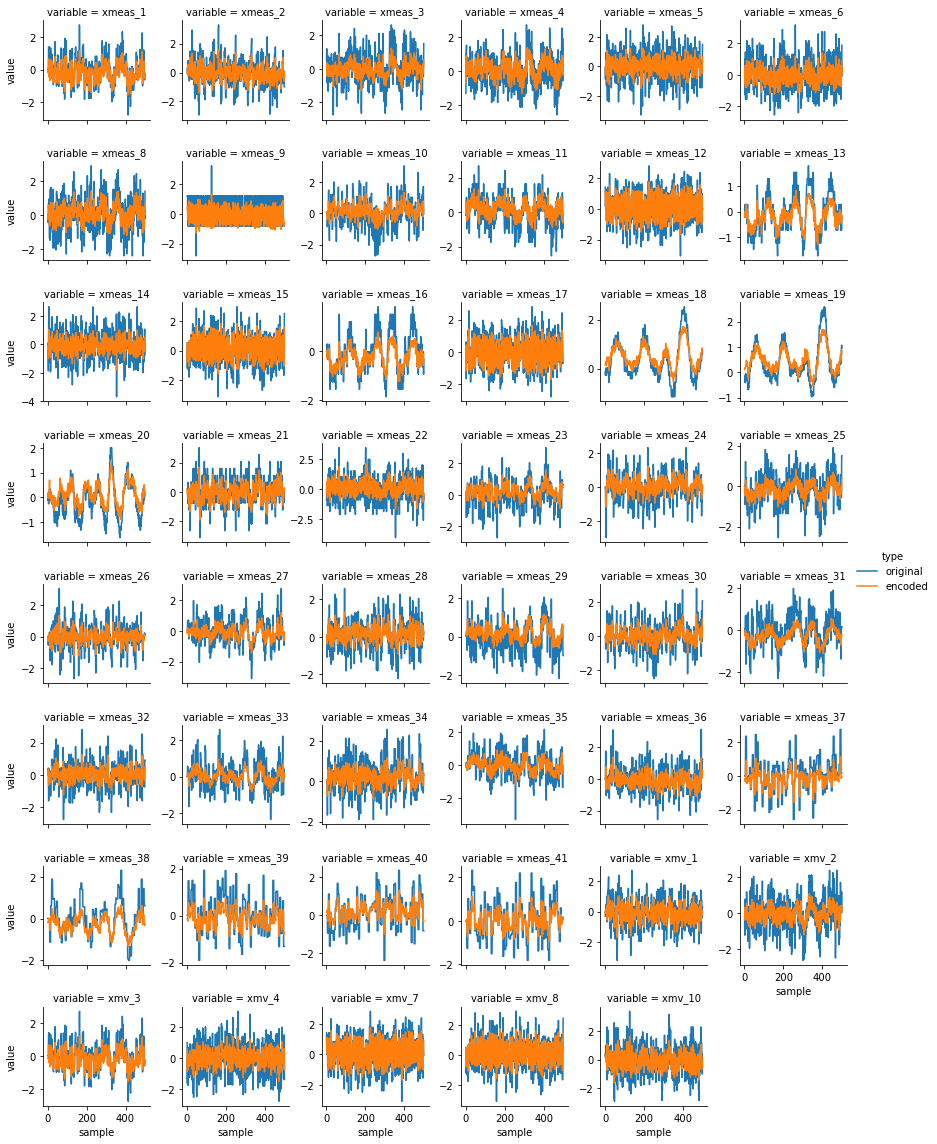

In [13]:
X_train_scaled['faultNumber'] = X_train_normal.faultNumber.values
X_train_scaled['simulationRun'] = X_train_normal.simulationRun.values
X_train_scaled['sample'] = X_train_normal['sample'].values

X_train_pred['faultNumber'] = X_train_normal.faultNumber.values
X_train_pred['simulationRun'] = X_train_normal.simulationRun.values
X_train_pred['sample'] = X_train_normal['sample'].values

plot_encoded_variables(X_train_scaled, X_train_pred, 1, 'Encoded Variables')

In [23]:
# get a scaled fault example
X_fault_sample = X_train_faulty.loc[X_train_faulty.faultNumber == 3]
fault_scaled = pd.DataFrame(scaler.transform(X_fault_sample[pv_columns].values), columns=pv_columns)
fault_windowed = LSTMAutoencoder.created_windowed_dataset(fault_scaled.values, window=window, batch_size=K)

# predict the fault example
fault_pred_df = pd.DataFrame(inverse_transform(model.predict(fault_windowed)), columns=pv_columns)
fault_pred_df['faultNumber'] = X_fault_sample.faultNumber.values
fault_pred_df['simulationRun'] = X_fault_sample.simulationRun.values
fault_pred_df['sample'] = X_fault_sample['sample'].values

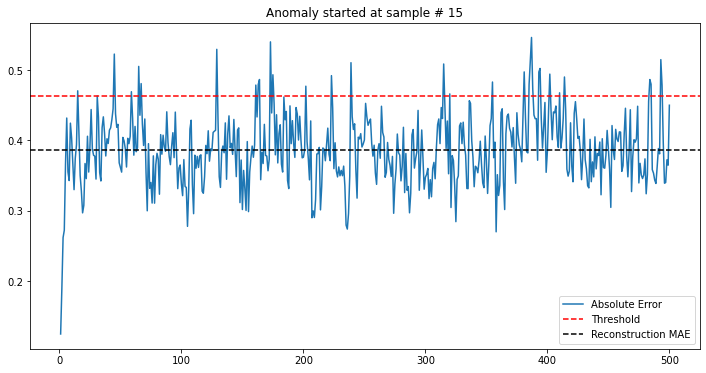

In [24]:
# calculate the reconstruction error
fault_pred_df['loss_mae'] = np.mean(np.abs(fault_pred_df - fault_scaled), axis=1)
plot_simulation_anomalies(fault_pred_df, 1, threshold)

## References
* https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf
* https://machinelearningmastery.com/lstm-autoencoders/